In [1]:
import os
import numpy as np
import pandas as pd

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures


from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, LassoLars, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor

from sklearn.feature_selection import RFE, RFECV, SelectFromModel, SelectKBest, SelectPercentile, f_regression, mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import tensorflow as tf
from tensorflow import keras

In [17]:
np.random.seed(42)
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [9]:
path = '~/WorkDocs/Code/diamonds/data/diamonds_20200602_preprocess.csv'
df = pd.read_csv(path)
df.head()

,price,carat,depth,lxwRatio,table,sellingIndex,hasVisualization,length,width,height,cat_clarity,cat_color,cat_cut,cat_culet,cat_polish,cat_symmetry,cat_fluorescence_reduced
0,10001,1.50,59.9,1.01,60.0,0.191319,1,7.45,7.40,4.44,1,3,2,4,2,2,4
1,10002,1.51,62.7,1.01,57.0,0.333796,0,7.32,7.26,4.57,2,3,2,4,2,2,4
2,10004,1.05,61.7,1.00,57.0,0.193977,1,6.52,6.49,4.02,5,6,2,4,2,2,2
3,10005,1.35,62.1,1.01,58.0,0.245716,1,7.07,7.03,4.38,2,4,2,4,2,2,4
4,10005,1.40,62.7,1.01,58.0,0.561808,1,7.06,7.12,4.44,4,3,2,4,2,2,4


In [7]:
# we can capture symmetry by directly using length/width
df['length/width'] = df['length'] / df['width']

In [8]:
df.describe()

,price,carat,depth,lxwRatio,table,sellingIndex,hasVisualization,length,width,height,cat_clarity,cat_color,cat_cut,cat_culet,cat_polish,cat_symmetry,cat_fluorescence_reduced,length/width
count,14705.000000,14705.000000,14705.000000,14705.000000,14705.000000,14705.000000,14705.000000,14705.000000,14705.000000,14705.000000,14705.000000,14705.000000,14705.000000,14705.000000,14705.000000,14705.000000,14705.000000,14705.000000
mean,17032.758177,1.831152,62.056307,1.007108,57.966066,0.260637,0.711595,7.769472,7.769338,4.820979,2.843047,4.157293,1.839238,3.887657,1.961850,1.892690,3.398300,1.000062
std,4316.882473,0.399186,1.195928,0.004762,1.755220,0.179514,0.453036,0.553215,0.555594,0.357458,1.727052,1.987091,0.420176,0.521857,0.197164,0.332811,0.968497,0.006621
min,10001.000000,0.900000,55.300000,1.000000,52.000000,0.000870,0.000000,6.060000,6.110000,1.510000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.972585
25%,14074.000000,1.520000,61.600000,1.000000,57.000000,0.115079,0.000000,7.370000,7.370000,4.570000,1.000000,3.000000,2.000000,4.000000,2.000000,2.000000,3.000000,0.993902
50%,16338.000000,1.820000,62.300000,1.010000,58.000000,0.217766,1.000000,7.800000,7.800000,4.850000,3.000000,4.000000,2.000000,4.000000,2.000000,2.000000,4.000000,1.002478
75%,19655.000000,2.010000,62.700000,1.010000,59.000000,0.375305,1.000000,8.090000,8.100000,5.040000,4.000000,6.000000,2.000000,4.000000,2.000000,2.000000,4.000000,1.006079
max,29994.000000,4.030000,67.900000,1.030000,68.000000,0.918382,1.000000,10.190000,10.190000,6.390000,7.000000,7.000000,3.000000,4.000000,2.000000,2.000000,4.000000,1.022636


In [156]:
dv = 'price'
# but given length/width stdev so small, we throw it out
iv_exclude_list = [dv, 'lxwRatio', 'cat_symmetry', 'length/width']
iv = [c for c in df.columns if c not in iv_exclude_list]

In [157]:
print(iv)

['carat', 'depth', 'table', 'sellingIndex', 'hasVisualization', 'length', 'width', 'height', 'cat_clarity', 'cat_color', 'cat_cut', 'cat_culet', 'cat_polish', 'cat_fluorescence_reduced']


In [158]:
# Hold out 0.2 as test data, split remaining to 0.67 vs 0.33 for train and validation
X, y = df[iv], df[dv]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=SEED)

In [159]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

In [160]:
# create a clean version of polynomial feature names
poly_feature_names = poly_features.get_feature_names()

feature_maps = {}
for i in range(len(iv)):
    feature_maps['x{}'.format(i)] = iv[i]
    
poly_feature_names_clean = []
for name in poly_feature_names:
    if ' ' in name:
        new_name = ' '.join([feature_maps[item] for item in name.split(' ')])
    elif '^' in name:
        x, degree = name.split('^')
        new_name = '^'.join([feature_maps[x], degree])
    else:
        new_name = feature_maps[name]
    poly_feature_names_clean.append(new_name)

In [161]:
def print_cv_score(model, x, y, cv=5):
    scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=5)
    root_scores = np.sqrt(-scores)
    print("Root mean squared error: %0.2f (+/- %0.2f)" % (root_scores.mean(), root_scores.std() * 2))
    return root_scores

In [162]:
lr = LinearRegression()
lr_scores = print_cv_score(lr, X_train, y_train)

Root mean squared error: 1865.10 (+/- 85.25)


In [163]:
lr = LinearRegression()
lr_poly2_scores = print_cv_score(lr, X_train_poly, y_train)

Root mean squared error: 1142.88 (+/- 45.73)


In [164]:
et = ExtraTreesRegressor(n_estimators=100)
et = et.fit(X_train_poly, y_train)

In [165]:
def plot_top_n_features(importances, feature_names, n=10):
    top_n_inds = importances.argsort()[-n:][::-1]
    top_n_names = [feature_names[i] for i in top_n_inds]
    top_n_values = importances[top_n_inds]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.barplot(x=top_n_values, y=top_n_names, ax=ax)

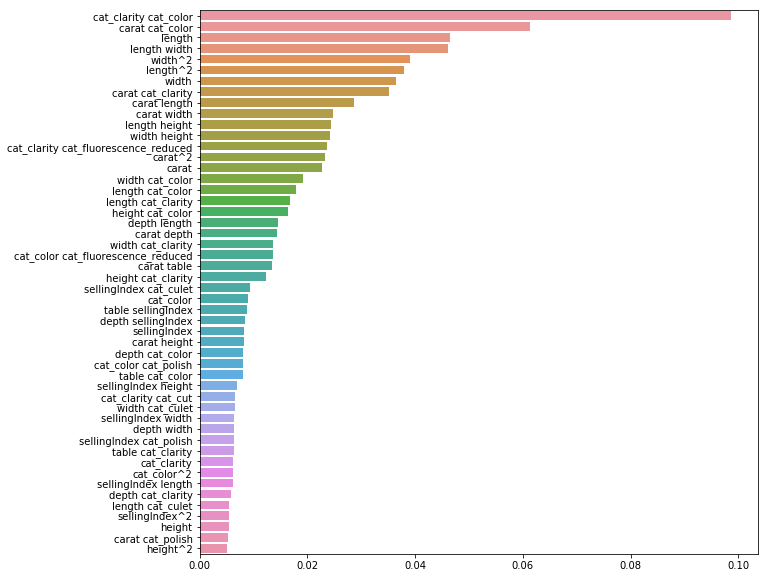

In [166]:
feature_importances = et.feature_importances_

plot_top_n_features(feature_importances, poly_feature_names_clean, 50)

In [167]:
X_train_poly_et = SelectFromModel(et, prefit=True, threshold="median").transform(X_train_poly)
print(X_train_poly_et.shape)
lr_poly2_scores = print_cv_score(lr, X_train_poly_et, y_train)

(11764, 60)
Root mean squared error: 1240.75 (+/- 53.72)


In [ ]:
lr = LinearRegression()
lr.fit(X_train_poly, y_train)

predictions = lr.predict(X_train_poly)

In [112]:
X_train.loc[12608,:]

carat                        1.300000
depth                       62.100000
table                       57.000000
sellingIndex                 0.673732
hasVisualization             1.000000
length                       6.950000
width                        6.980000
height                       4.330000
cat_clarity                  7.000000
cat_color                    7.000000
cat_cut                      2.000000
cat_culet                    4.000000
cat_polish                   2.000000
cat_symmetry                 2.000000
cat_fluorescence_reduced     4.000000
Name: 12608, dtype: float64

In [125]:
y_train.loc[13655]

23505

In [124]:
(predictions.reshape(-1) - y_train).sort_values(ascending=False)

13655    4218.013839
12656    4218.013839
13903    4142.958541
12904    4142.958541
14250    4005.821647
13335    3729.608978
7961     3662.898052
6962     3662.898052
8960     3662.898052
14009    3595.660794
12074    3577.778568
13073    3577.778568
13394    3512.125229
12395    3512.125229
11110    3511.428764
10111    3511.428764
10140    3510.894466
9141     3510.894466
11139    3510.894466
6063     3475.993627
8061     3475.993627
7062     3475.993627
13756    3454.840565
12757    3454.840565
12925    3442.515002
11640    3439.667632
9642     3439.667632
10641    3439.667632
13879    3430.551664
12880    3430.551664
            ...     
14682   -4596.816535
13590   -4647.872593
12591   -4647.872593
14497   -4756.580083
14690   -4783.699815
14487   -4795.811148
13526   -4912.533354
12527   -4912.533354
14553   -5022.185978
14323   -5077.887580
6193    -5088.722931
7192    -5088.722931
8191    -5088.722931
14240   -5139.943597
14609   -5167.272084
10808   -5195.009257
14156   -5217

Text(0.5, 1.0, 'Residual plot')

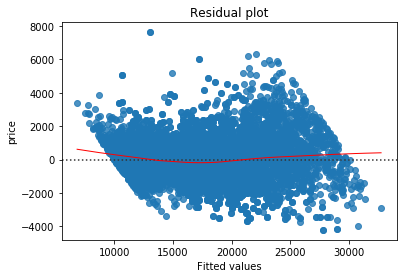

In [95]:
sns.residplot(predictions.reshape(-1), y_train, lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

Text(0.5, 1.0, 'Normal Q-Q Plot')

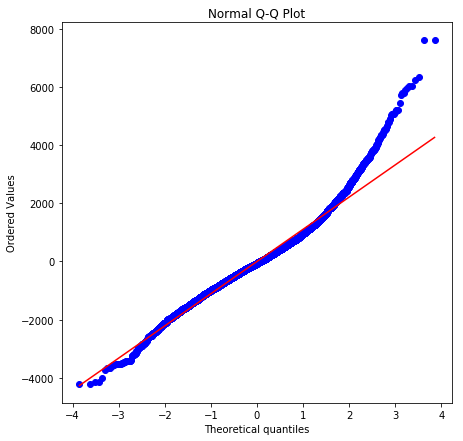

In [96]:
residuals = y_train - predictions.reshape(-1)

plt.figure(figsize=(7,7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

Text(0.5, 0, 'Fitted value')

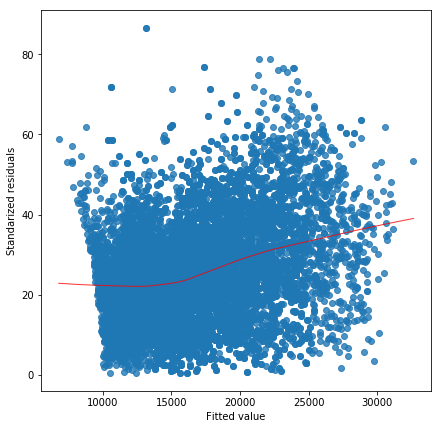

In [72]:
model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.figure(figsize=(7,7))
sns.regplot(predictions.reshape(-1), model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")

In [62]:
ridge = Ridge(alpha=1.0)
ridge_scores = print_cv_score(ridge, X_train_poly, y_train)

Root mean squared error: 1149.71 (+/- 56.28)


In [47]:
X_train_poly.shape

(11764, 152)

In [27]:
ada = AdaBoostRegressor(random_state=SEED, n_estimators=50)
ada_scores = print_cv_score(ada, X_train_poly, y_train)

Root mean squared error: 2100.41 (+/- 69.37)


In [19]:
rr = BayesianRidge()
rr_scores = print_cv_score(rr, X_train_poly, y_train)

Root mean squared error: 1147.56 (+/- 54.89)


In [ ]:
svr = SVR(kernel='linear')
svr_scores = print_cv_score(svr, X_train_poly, y_train)

In [24]:
params = {'n_estimators': 50,
          'max_depth': 6,
          'min_samples_split': 3,
          'learning_rate': 0.01,
          'loss': 'ls'}
gbr = GradientBoostingRegressor(**params)
gbr_scores = print_cv_score(gbr, X_train_poly, y_train)

Root mean squared error: 3006.36 (+/- 77.42)


In [130]:
# this is prone to overfitting
tree = DecisionTreeRegressor(min_samples_split=10, random_state=SEED)
tree_scores = print_cv_score(tree, X_train_poly, y_train)

Root mean squared error: 1164.80 (+/- 44.96)


In [61]:
rf = RandomForestRegressor(n_estimators=50, max_depth=8, random_state=SEED)
rf_scores = print_cv_score(rf, X_train_poly, y_train)

Root mean squared error: 1290.16 (+/- 61.72)


In [131]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=5, random_state=SEED)
rf_scores = print_cv_score(rf, X_train, y_train)

Root mean squared error: 2410.76 (+/- 108.47)
